# Testing iterative methods

In [30]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
# from modules_no_st import coh_ang_calc
from skimage.transform import rescale
from skimage import color
from numpy.lib.stride_tricks import sliding_window_view

In [31]:
from skimage.filters import gaussian

def structure_tensor_calc(image, sigma_to_ydim_ratio):
    I_x, I_y = ddx_gaussian_convolve(
        image, sigma_to_ydim_ratio=sigma_to_ydim_ratio, truncate=2
    )

    # structure tensor
    mu_20 = I_x**2
    mu_02 = I_y**2

    # k_20_real, k_20_im, k_11
    return mu_20 - mu_02, 2 * I_x * I_y, mu_20 + mu_02

def ddx_gaussian_convolve(
    image: np.ndarray, sigma=-1, sigma_to_ydim_ratio=-1, truncate=3, mode="l2"
):
    if sigma == -1:
        if sigma_to_ydim_ratio == -1:
            sigma = 1
        else:
            sigma = image.shape[0] * sigma_to_ydim_ratio
    return ndi.gaussian_filter(
        image, sigma, order=(0, 1), truncate=truncate, mode="reflect"
    ), ndi.gaussian_filter(
        image, sigma, order=(1, 0), truncate=truncate, mode="wrap"
    )  # ix, iy

def kval_gaussian(k_20_re, k_20_im, k_11, sigma):
    max_std = 3.0  # cut off gaussian after 3 standard deviations
    return (
        gaussian(k_20_re, sigma=sigma, truncate=max_std),
        gaussian(k_20_im, sigma=sigma, truncate=max_std),
        gaussian(k_11, sigma=sigma, truncate=max_std),
    )

def coh_ang_calc(image, sigma_to_ydim_ratio, sigma_inner=2, epsilon=1e-3):
    # image: 2d grayscale image, perchance already mean downscaled a bit
    # sigma_outer: sigma for gradient detection
    # sigma_inner: sigma controlling bandwidth of angles detected
    # epsilon: prevent div0 error for coherence
    # kernel_radius: kernel size for gaussians - kernel will be 2*kernel_radius + 1 wide

    k_20_re, k_20_im, k_11 = structure_tensor_calc(image, sigma_to_ydim_ratio)

    # this is sampling local area with w(p)
    k_20_re, k_20_im, k_11 = kval_gaussian(k_20_re, k_20_im, k_11, sigma_inner)

    # return coherence (|k_20|/k_11), orientation (angle of k_20)
    return (k_20_re**2 + k_20_im**2) / (k_11 + epsilon) ** 2, np.arctan2(
        k_20_im, k_20_re
    )

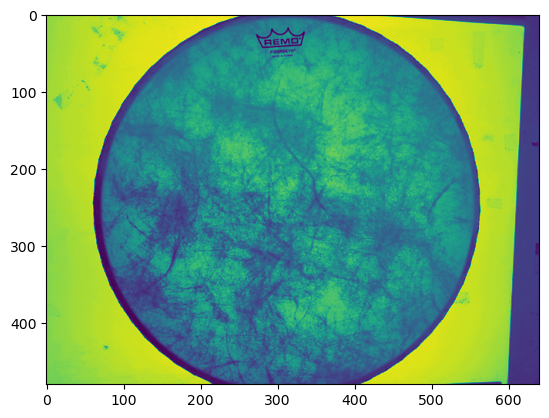

In [32]:
drumhead = cv.imread("drumhead.jpg")
drum_gray = color.rgb2gray(drumhead)
plt.imshow(drum_gray)

In [33]:
# coh, ang = coh_ang_calc(drum_gray)
# plt.imshow(coh)

In [34]:
# plt.imshow(ang)

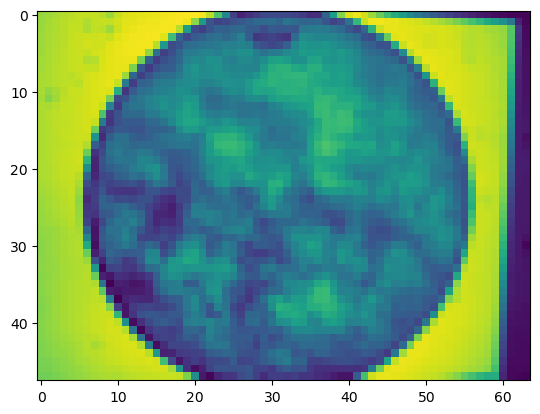

In [35]:
drum_small = rescale(drum_gray, 0.1)
plt.imshow(drum_small)

In [36]:
# iteratively apply diffusion steps - maybe add time_step, analagous to sigma of filter?
def diffuse(img, ksize, diffusion_step, num_steps):
    assert ksize>=1 and ksize%2==1, "kernel must be >= 1 and odd"
    assert num_steps >=0, "must have nonnegative number of steps - no reverse diffusion yet :)"
    if num_steps == 0:
        return img # img without filtering is just img
    
    # shouldn't be bottleneck (i hope)
    for _ in range(num_steps):
        img = diffusion_step(img, ksize)
    return img

def border(img, border_width):
    return cv.copyMakeBorder(img, border_width, border_width, border_width, border_width, cv.BORDER_WRAP)

# kernel diameter of 3, average pixels
# responsible for bordering img before convolution-adjacent operation
def linear_diffusion_step(img, ksize):
    k_radius = ksize//2
    new_img = np.zeros_like(img, dtype=float)
    # print(new_img.shape)
    img_padded = border(img, k_radius)
    h, w = new_img.shape
    for r in range(h):
        for c in range(w):
            # normalization = 1/(ksize * ksize)
            normalization = 1
            avg = np.mean(img_padded[r:r+2*k_radius+1, c:c+2*k_radius+1])
            new_img[r, c] = normalization*avg
    return new_img

# Idea: instead of using 2d for loop, create ndarry of shape(img.shape[0], img.shape[1], ksize, ksize)
# Then, perform almost-convolution with filter[r, c, x, y] *= img[r-ksize//2+x]
# check out numpy vectorize and sliding-window
def linear_diffusion_step_smarter(img, ksize):
    filter = np.ones(img.shape + (ksize, ksize))
    img_padded = border(img, ksize//2)
    window_view = sliding_window_view(img_padded, (ksize, ksize))
    # print(filter.shape, window_view.shape)
    product = filter * window_view
    final_img = np.mean(product, axis=(2, 3))
    return final_img

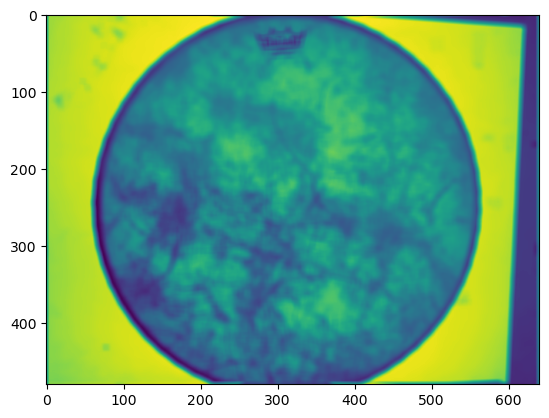

In [37]:
faster_maybe = linear_diffusion_step_smarter(drum_gray, 9)
plt.imshow(faster_maybe)

2.8014891147613525 0.04149436950683594


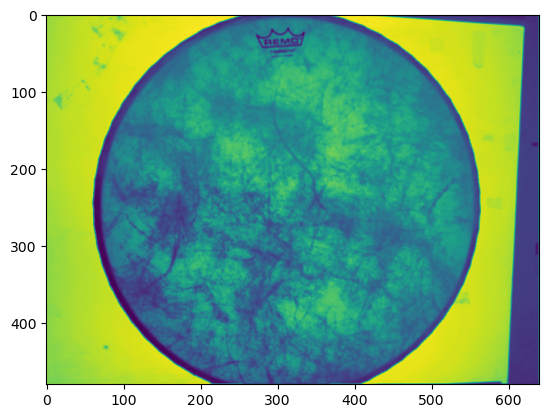

In [38]:
# runtime comparison
import time
t0 = time.time()
blur_drumhead = diffuse(drum_gray, 3, linear_diffusion_step, 1)
t1 = time.time()
blur_drumhead_faster = diffuse(drum_gray, 3, linear_diffusion_step_smarter, 1)
t2 = time.time()
plt.imshow(blur_drumhead)
print(t1 - t0, t2 - t1)

In [39]:
# Note: while both methods yield the same result, using numpy is orders of magnitude faster :)
print((t1-t0)/(t2-t1))
(blur_drumhead == blur_drumhead_faster).all()

67.51492185704436


True

In [40]:
def a_diffusion(img, ksize, sigma=1):
    pass

In [41]:
angle = np.pi * 2
coherence = 0.5
sigma = 1

def RtSR(angle, coherence, sigma):
    sigma_1 = (1 - coherence) * sigma
    R = np.array([[np.cos(angle), -1*np.sin(angle)],
                [np.sin(angle), np.cos(angle)]])
    S = np.array([[sigma_1, 0],
                [0, sigma]])

    SR = np.matmul(S, R)
    return np.matmul(R.T, SR)

In [42]:
def xtAx(x, A):
    return np.matmul(x.T, np.matmul(A, x))

def exponent(x, y, theta, coherence, sigma):
    return xtAx(np.array([x, y], RtSR(theta, coherence, sigma)))

In [43]:
# NOTE: calculation for rotated matrix is WRONG! look up how to actually do it- it's change of basis, not just rotating a vector.
def angled_gaussian(x, y, theta, coherence, sigma=1):
    theta += np.pi/2
    rtsr = RtSR(theta, coherence, sigma)
    xtax = xtAx(np.array([x, y]), rtsr)
    return np.exp(-1*xtax)

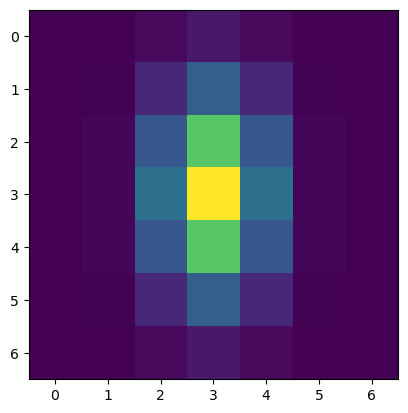

In [44]:
img = np.array([[angled_gaussian(x, y, 0, .7) for x in range(-3, 4)] for y in range(-3, 4)])
img /= img.mean()
plt.imshow(img)

In [45]:
def create_shifted_kernel():
    k_radius = 2
    k_range = np.arange(-k_radius, k_radius + 1, dtype=int)
    np.array(np.meshgrid(k_range, k_range))

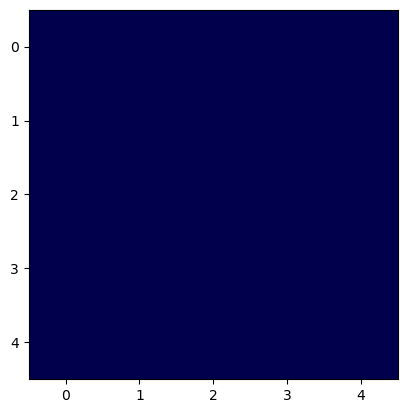

In [46]:
plt.imshow(np.ones((5, 5))*10, cmap='seismic')

In [47]:
img = drum_gray # shape (height, width)
def anisotropic_diffusion(img, sigma_inner, sigma_blur, k_radius=3):
    img_dimensions = img.shape
    k_size = k_radius*2+1
    coherence, theta = coh_ang_calc(img, sigma_inner, k_radius) # shape (height, width)
    sigma_2 = sigma_blur # shape (1)
    sigma_1 = (sigma_2 * (1 - coherence*0.9)).reshape(img_dimensions + (1, 1)) # shape (height, width)
    
    s = np.sin(theta).reshape(img_dimensions + (1, 1)) # shape (height, width)
    c = np.cos(theta).reshape(img_dimensions + (1, 1)) # shape (height, width)
    k_range = np.arange(-k_radius, k_radius + 1, dtype=int)
    x = k_range.reshape((1, 1, k_size, 1))
    y = k_range.reshape((1, 1, 1, k_size))

    # A = R^T @ S @ R
    # xtax = x^T @ A @ x
    # IMPORTANT: x = [x, y], so xtax should have shape (height, width, ksize, ksize)
    xtax = (sigma_1 * c * c + sigma_2 * s * s) * x * x + 2 * (sigma_1 - sigma_2) * c * s * x * y + (sigma_1 * s * s + sigma_2 * c * c) * y * y
    xtax = np.exp(-1 * xtax)
    xtax /= xtax.sum(axis=(2, 3)).reshape(img_dimensions + (1, 1)) # normalizing kernels to sum to 1
    expanded = sliding_window_view(border(img, k_radius), (k_radius*2+1, k_radius*2+1)) # shape (height, width, ksize, ksize), NOTE: MAKE SURE TO PAD IMAGE BEFORE EXPANDING
    filtered_img = (xtax * expanded).sum(axis=(2, 3))
    return filtered_img
filtered_img = anisotropic_diffusion(img, 2, 1)
plt.imshow(filtered_img, cmap='gray')

NameError: name 'ndi' is not defined

In [ ]:
plt.imshow(a_diffuse)

NameError: name 'a_diffuse' is not defined

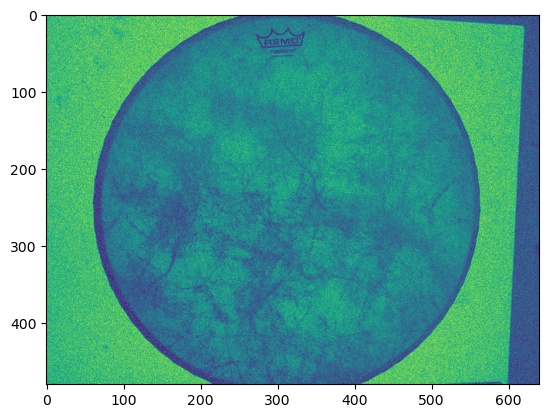

In [ ]:
drum_noisy = drum_gray + np.random.randn(*drum_gray.shape)/10
plt.imshow(drum_noisy)

In [ ]:
# plt.imshow(filtered_img - drum_gray + np.abs(filtered_img - drum_gray))
temp_func = lambda x, _ : anisotropic_diffusion(x, 2, 3, k_radius = 10)
a_diffuse = diffuse(drum_noisy, 7, temp_func, 3)


In [ ]:
(np.abs(drum_gray - drum_noisy)).mean(), (np.abs(drum_gray - a_diffuse)).mean()

(0.07976043014068543, 0.048867458047339454)

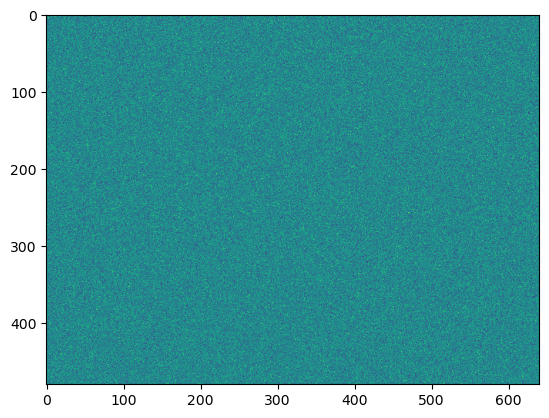

In [ ]:
plt.imshow(drum_noisy - drum_gray)

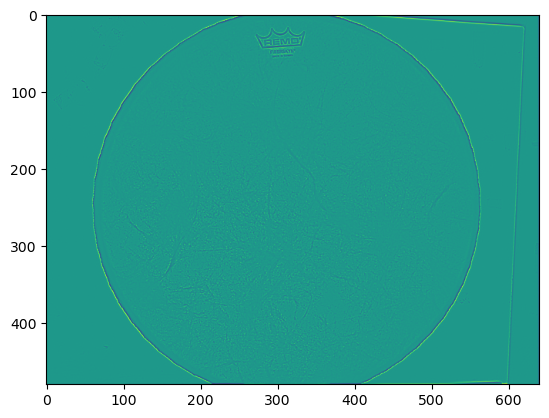

In [ ]:
plt.imshow(drum_gray - a_diffuse)

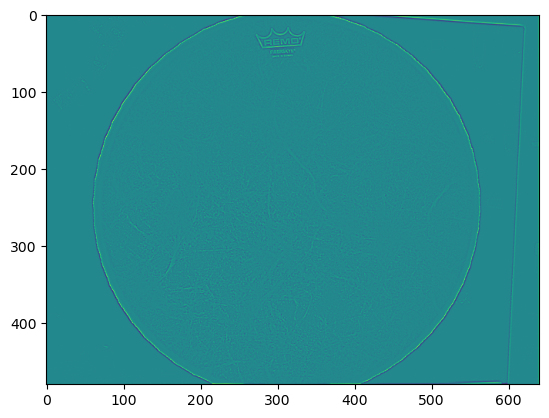

In [ ]:
plt.imshow(a_diffuse - drum_gray)

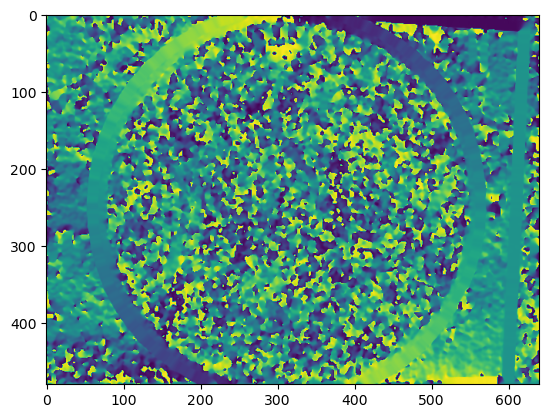

In [ ]:
temp1, temp2 = coh_ang_calc(drum_gray)
plt.imshow(temp2)